In [1]:
__imp

Libraries have been loaded


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display

from sklearn import metrics

In [4]:
set_plot_sizes(12,14,16)

### Load Processed Data

In [5]:
PATH = '../data/interim/dataset1/'

df_raw        = pd.read_pickle(PATH + 'application_train.pkl')

# bureau        = pd.read_pickle(PATH + 'bureau_train.pkl')
# df_raw        = pd.concat((df_raw.loc[:, ['SK_ID_CURR', 
#                                           'DAYS_BIRTH', 
#                                           'TARGET']], bureau), axis=1)

# bureau        = pd.read_pickle(PATH + 'bureau.pkl')
credit_bal    = pd.read_pickle(PATH + 'credit_card_balance.pkl')

### Modelling

In [6]:
%%time

# replace inf with null values
for col in df_raw.columns: df_raw[col] = df_raw[col].replace([np.inf, -np.inf], np.nan)
df_trn, y_trn, nas = proc_df(df_raw, 'TARGET', skip_flds=['SK_ID_CURR'])

CPU times: user 1.47 s, sys: 105 ms, total: 1.57 s
Wall time: 1.59 s


In [7]:
def split_vals(X, y, test_size=.3):
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, stratify=y, test_size=test_size, random_state=SEED)
    
    return X_trn, X_val, y_trn, y_val

In [8]:
def print_score(m, X_tr, y_tr, X_val, y_val):
    res = [metrics.log_loss(y_tr, m.predict_proba(X_tr)[:, 1]), 
           metrics.log_loss(y_val, m.predict_proba(X_val)[:, 1]),
           metrics.roc_auc_score(y_tr, m.predict_proba(X_tr)[:, 1]), 
           metrics.roc_auc_score(y_val, m.predict_proba(X_val)[:, 1])]
    
    print(res)

In [9]:
def get_oob(df_keep, y_trn, m=None):
    X_tr, X_val, y_tr, y_val = split_vals(df_keep, y_trn)
    
    if m is None:
        m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
    
    m.fit(X_tr, y_tr)
    print_score(m, X_tr, y_tr, X_val, y_val)
    
    return m

In [10]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [11]:
# set Random Forest to consider only a sample
set_rf_samples(50000)

In [12]:
%%time

m = RandomForestClassifier(n_estimators=50, 
                           min_samples_leaf=100, 
                           max_depth=7,
                           max_features=.5, 
                           n_jobs=-1)

m = get_oob(df_trn, y_trn, m)

[0.264770779087091, 0.2677640887063415, 0.6860319440741829, 0.6648717202043721]
CPU times: user 55.5 s, sys: 752 ms, total: 56.3 s
Wall time: 18.8 s


#### Feature Importance

In [24]:
fi = rf_feat_importance(m, df_trn); fi[:20]

,cols,imp
31,ratio_debt_credit_sum,0.144938
26,DAYS_CREDIT_mean,0.121824
0,DAYS_CREDIT_median,0.087360
19,mean_max_amt_overdue,0.080760
40,mean_days_credit_update,0.057428
7,recent_bureau_loans,0.052364
22,oldest_loan_employment,0.047629
35,oldest_loan_age,0.036620
15,AMT_CREDIT_SUM_amin,0.031473
11,AMT_CREDIT_SUM_median,0.022149


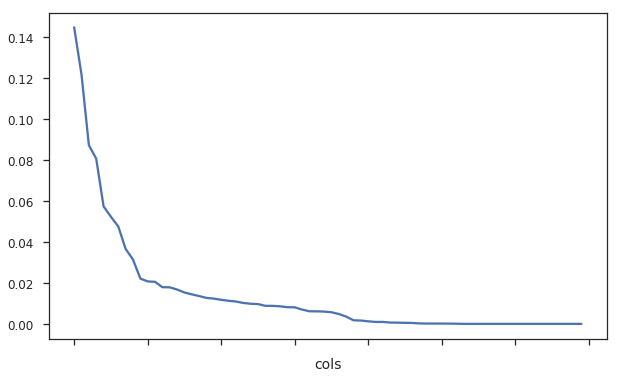

In [22]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

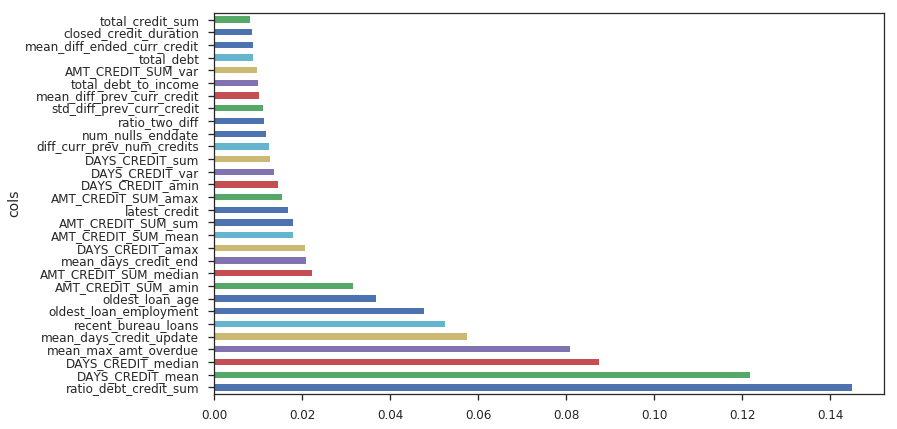

In [23]:
plot_fi(fi[:30]);

In [21]:
to_keep = fi[fi.imp>0.001].cols; len(to_keep)

24

In [22]:
df_keep = df_trn[to_keep].copy()

m = RandomForestClassifier(n_estimators=50, 
                           min_samples_leaf=100, 
                           max_depth=3,
                           max_features=.3, 
                           n_jobs=-1)

m = get_oob(df_keep, y_trn, m)

[0.2574672956392731, 0.25822626221473566, 0.7188262600309556, 0.7158669413564941]


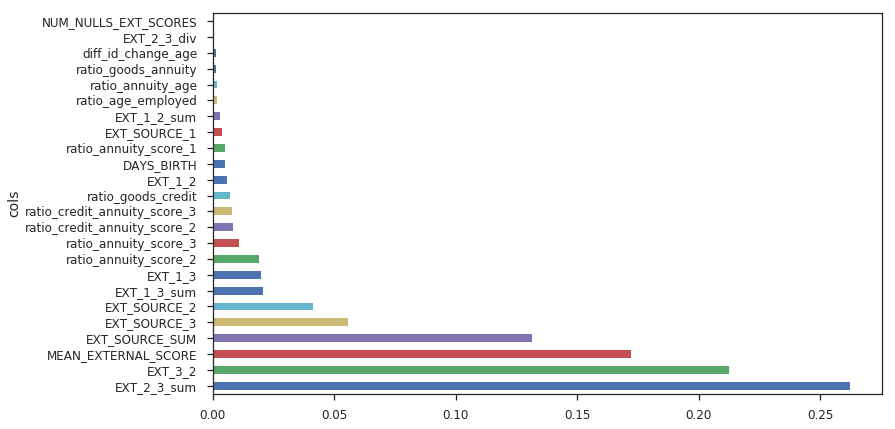

In [23]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:30]);

### EDA

#### AGE

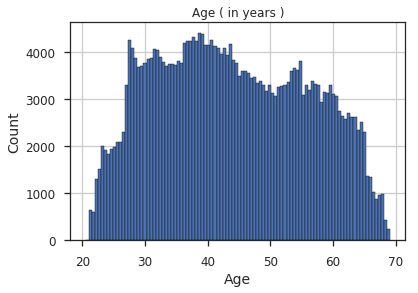

In [21]:
(-df_raw.DAYS_BIRTH / 365).hist(edgecolor='k', bins=100)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age ( in years )');

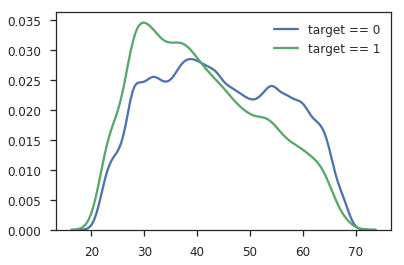

In [23]:
sns.kdeplot(-df_raw[y_trn == 0].DAYS_BIRTH / 365, label='target == 0')
sns.kdeplot(-df_raw[y_trn == 1].DAYS_BIRTH / 365, label='target == 1');

#### Employed

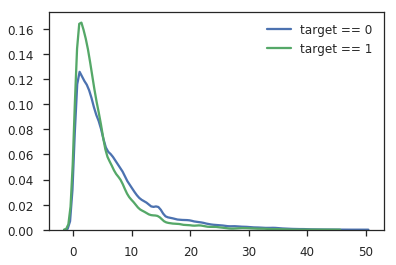

In [45]:
sns.kdeplot(-df_raw[y_trn==0].DAYS_EMPLOYED.replace({365243: np.nan}) / 365, label='target == 0')
sns.kdeplot(-df_raw[y_trn == 1].DAYS_EMPLOYED.replace({365243: np.nan}) / 365, label='target == 1');

#### Relationship between age and employed

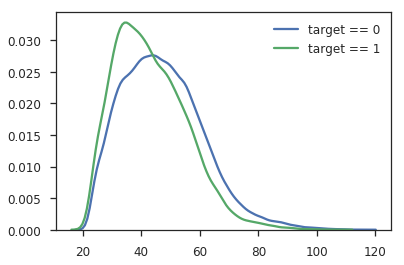

In [50]:
# Relationship bewtween age and employed

t1 = (-df_raw[y_trn==0].DAYS_BIRTH / 365) + (-df_raw[y_trn==0].DAYS_EMPLOYED.replace({365243: np.nan}) / 365)
t2 = (-df_raw[y_trn==1].DAYS_BIRTH / 365) + (-df_raw[y_trn==1].DAYS_EMPLOYED.replace({365243: np.nan}) / 365)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

#### Relationship between Age and External Source

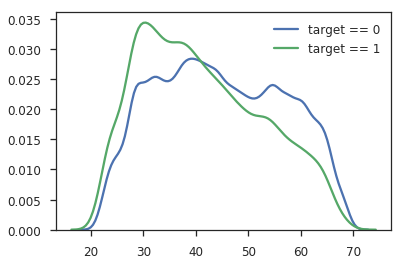

In [54]:
# Relationship between age and external scores
t1 = (-df_trn[y_trn==0].DAYS_BIRTH / 365) + (df_trn[y_trn==0].EXT_SOURCE_2)
t2 = (-df_trn[y_trn==1].DAYS_BIRTH / 365) + (df_trn[y_trn==1].EXT_SOURCE_2)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

#### Relationship between employed and external scores

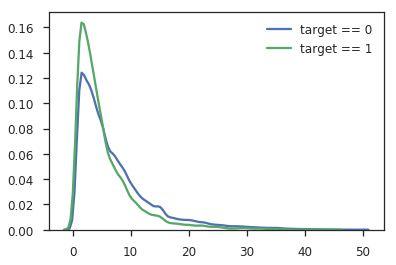

In [56]:
# Relationship between employed and external scores
t1 = (-df_trn[y_trn==0].DAYS_EMPLOYED.replace({365243: np.nan}) / 365) + (df_trn[y_trn==0].EXT_SOURCE_2)
t2 = (-df_trn[y_trn==1].DAYS_EMPLOYED.replace({365243: np.nan}) / 365) + (df_trn[y_trn==1].EXT_SOURCE_2)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

#### Relationship between age, employed and external source

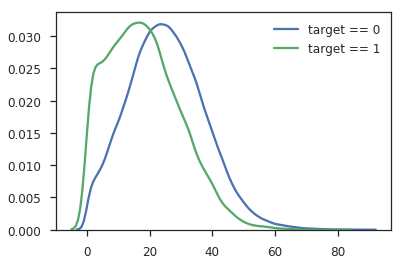

In [64]:
# Relationship bewtween age and employed

t1 = ((-df_trn[y_trn==0].DAYS_BIRTH / 365) +\
     (-df_trn[y_trn==0].DAYS_EMPLOYED.replace({365243: np.nan}) / 365)) *\
     (df_trn[y_trn==0].EXT_SOURCE_2)

t2 = ((-df_trn[y_trn==1].DAYS_BIRTH / 365) +\
     (-df_trn[y_trn==1].DAYS_EMPLOYED.replace({365243: np.nan}) / 365)) *\
     (df_trn[y_trn==1].EXT_SOURCE_2)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

#### Annuity and Target

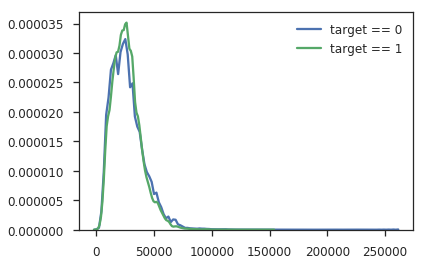

In [115]:
# annuity and target

t1 = (df_trn[y_trn==0].AMT_ANNUITY)
t2 = (df_trn[y_trn==1].AMT_ANNUITY)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

#### Annuity, Credit and Target

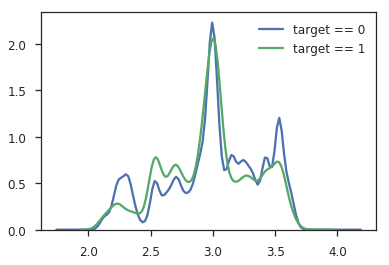

In [119]:
# annuity, credit and target

t1 = (df_trn[y_trn==0].AMT_CREDIT.map(np.log1p)) - (df_trn[y_trn==0].AMT_ANNUITY.map(np.log1p))
t2 = (df_trn[y_trn==1].AMT_CREDIT.map(np.log1p)) - (df_trn[y_trn==1].AMT_ANNUITY.map(np.log1p))

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

#### Relationship between age, employed and ext source 3

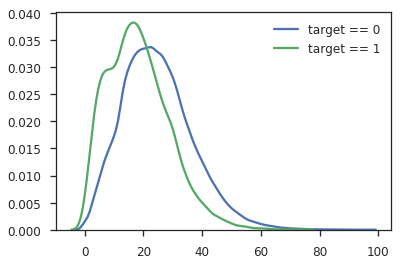

In [68]:
# Relationship bewtween age and employed

t1 = ((-df_trn[y_trn==0].DAYS_BIRTH / 365) +\
     (-df_trn[y_trn==0].DAYS_EMPLOYED.replace({365243: np.nan}) / 365)) *\
     (df_trn[y_trn==0].EXT_SOURCE_3)

t2 = ((-df_trn[y_trn==1].DAYS_BIRTH / 365) +\
     (-df_trn[y_trn==1].DAYS_EMPLOYED.replace({365243: np.nan}) / 365)) *\
     (df_trn[y_trn==1].EXT_SOURCE_3)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

#### Relationship between age and gender

In [72]:
# Relationship with age and gender
df_trn.loc[(-df_trn.DAYS_BIRTH / 365) < 40, 'CODE_GENDER'].value_counts(normalize=True)

1    0.594199
2    0.405777
3    0.000024
Name: CODE_GENDER, dtype: float64

In [73]:
df_trn.loc[(-df_trn.DAYS_BIRTH / 365) >= 40, 'CODE_GENDER'].value_counts(normalize=True)

1    0.703655
2    0.296340
3    0.000006
Name: CODE_GENDER, dtype: float64

#### Relationship between gender, age and target

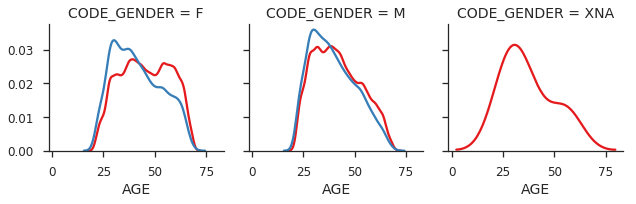

In [96]:
# Gender, Age and Target
x = df_raw.loc[:, ['CODE_GENDER', 'DAYS_BIRTH', 'TARGET']].copy()
x.loc[:, 'AGE'] = (-x.DAYS_BIRTH / 365)

g = sns.FacetGrid(x, 
                  col='CODE_GENDER', 
                  hue='TARGET', 
                  palette='Set1')
g = g.map(sns.kdeplot, 'AGE')

#### Relationship between gender, employed and target

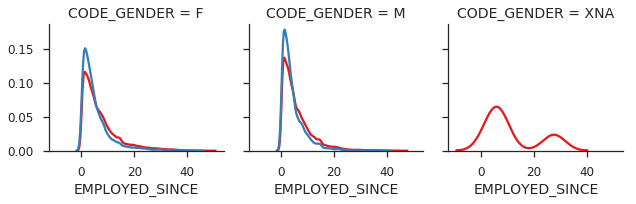

In [105]:
# Gender, Days Employed and Target
x = df_raw.loc[:, ['CODE_GENDER', 'DAYS_EMPLOYED', 'TARGET']].copy()
x.loc[:, 'EMPLOYED_SINCE'] = (-x.DAYS_EMPLOYED.replace({365243: np.nan}) / 365)

g = sns.FacetGrid(x, 
                  col='CODE_GENDER', 
                  hue='TARGET', 
                  palette='Set1')
g = g.map(sns.kdeplot, 'EMPLOYED_SINCE')

#### Relationship between gender, age, days since last time ID was changed and target

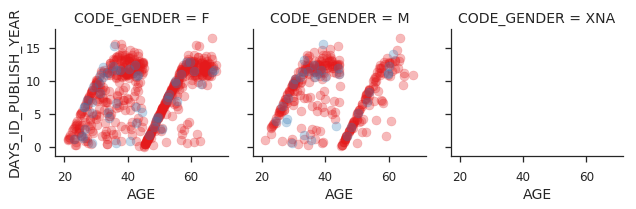

In [108]:
# Gender, Age, Days since last time ID was changed and Target
x = df_raw.loc[:, ['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'TARGET']].sample(n=1000).copy()
x.loc[:, 'AGE'] = (-x.DAYS_BIRTH / 365)
x.loc[:, 'DAYS_ID_PUBLISH_YEAR'] = (-x.DAYS_ID_PUBLISH / 365)

g = sns.FacetGrid(x, 
                  col='CODE_GENDER', 
                  hue='TARGET', 
                  palette='Set1')
g = g.map(plt.scatter, 'AGE', 'DAYS_ID_PUBLISH_YEAR', alpha=.3)

#### Relationship between gender, days since last time id and registration documents were updated and Target

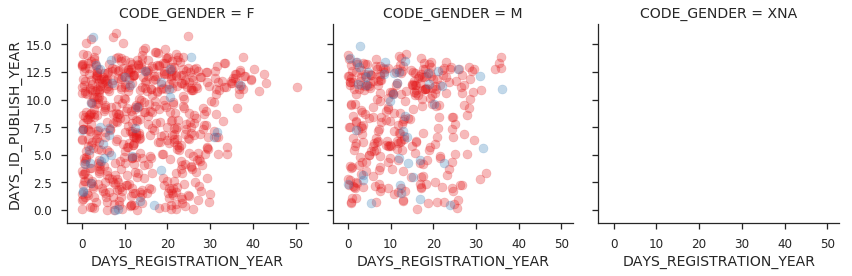

In [110]:
# Gender, Days since last time id was changed, days since last time registration was changed and target
x = df_raw.loc[:, ['CODE_GENDER', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'TARGET']].sample(n=1000).copy()
x.loc[:, 'DAYS_REGISTRATION_YEAR'] = (-x.DAYS_REGISTRATION / 365)
x.loc[:, 'DAYS_ID_PUBLISH_YEAR']   = (-x.DAYS_ID_PUBLISH / 365)

g = sns.FacetGrid(x, 
                  col='CODE_GENDER', 
                  hue='TARGET', 
                  palette='Set1',
                  size=4
                 )
g = g.map(plt.scatter, 'DAYS_REGISTRATION_YEAR', 'DAYS_ID_PUBLISH_YEAR', alpha=.3)

#### Relationship between Age ( Bucket ), Days since last time id was changed, days since last time registration was changed and target

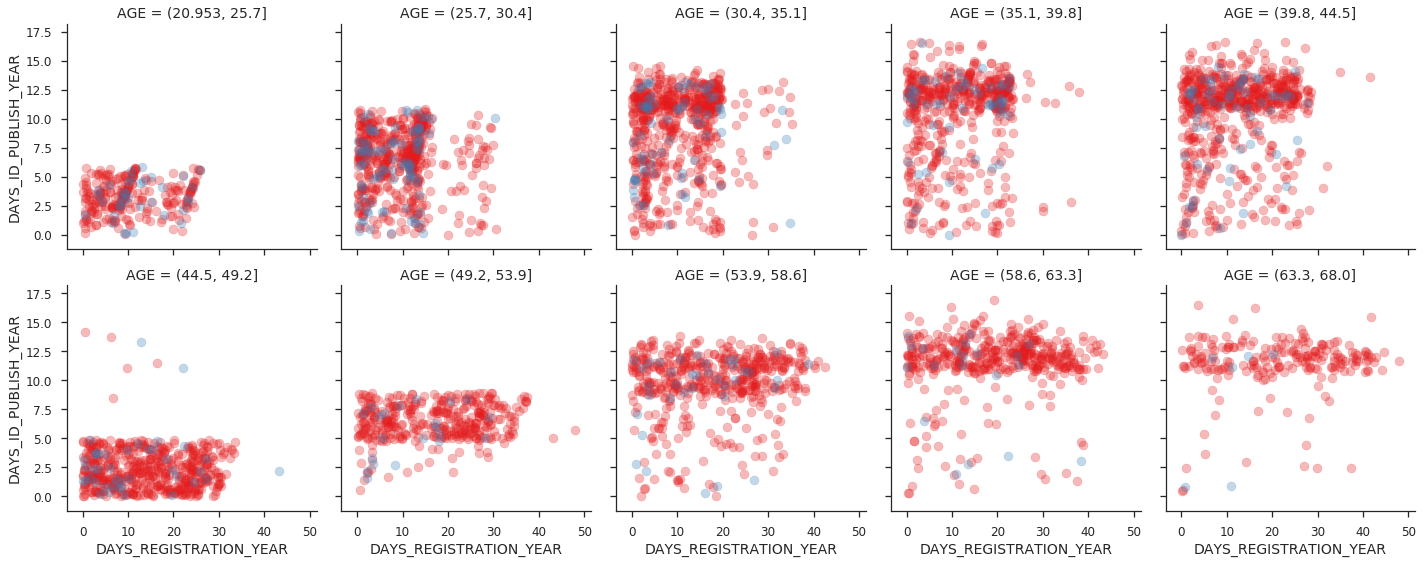

In [114]:
# Age ( Bucket ), Days since last time id was changed, days since last time registration was changed and target

x = df_raw.loc[:, ['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'TARGET']].sample(n=5000).copy()
x.loc[:, 'AGE']                    = pd.cut((-x.DAYS_BIRTH / 365).astype(np.int), bins=10)
x.loc[:, 'DAYS_REGISTRATION_YEAR'] = (-x.DAYS_REGISTRATION / 365)
x.loc[:, 'DAYS_ID_PUBLISH_YEAR']   = (-x.DAYS_ID_PUBLISH / 365)

g = sns.FacetGrid(x, 
                  col='AGE', 
                  hue='TARGET', 
                  palette='Set1',
                  size=4,
                  col_wrap=5
                 )

g = g.map(plt.scatter, 'DAYS_REGISTRATION_YEAR', 'DAYS_ID_PUBLISH_YEAR', alpha=.3)

#### Relationship between ratio of annuity to credit for different age groups

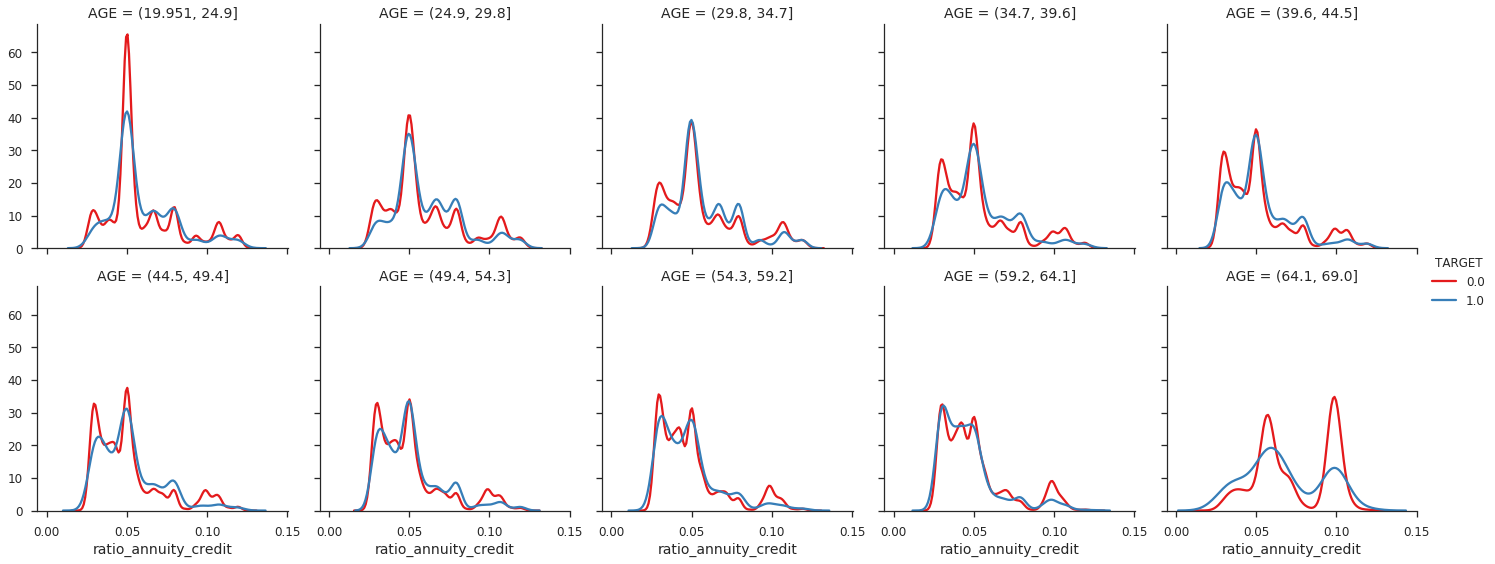

In [16]:
# Relationship between ratio of annuity to credit for different age groups
x = df_raw.loc[:, ['DAYS_BIRTH', 'AMT_ANNUITY', 'AMT_CREDIT', 'TARGET']].copy()
x.loc[:, 'AGE'] = pd.cut((-x.DAYS_BIRTH / 365).astype(np.int), bins=10)
x.loc[:, 'ratio_annuity_credit'] = (x.AMT_ANNUITY / x.AMT_CREDIT)

g = sns.FacetGrid(x, 
                  col='AGE', 
                  hue='TARGET', 
                  palette='Set1',
                  size=4,
                  col_wrap=5
                 )
g = g.map(sns.kdeplot, 'ratio_annuity_credit').add_legend();

#### Relationship between ratio of annuity to credit for different age groups

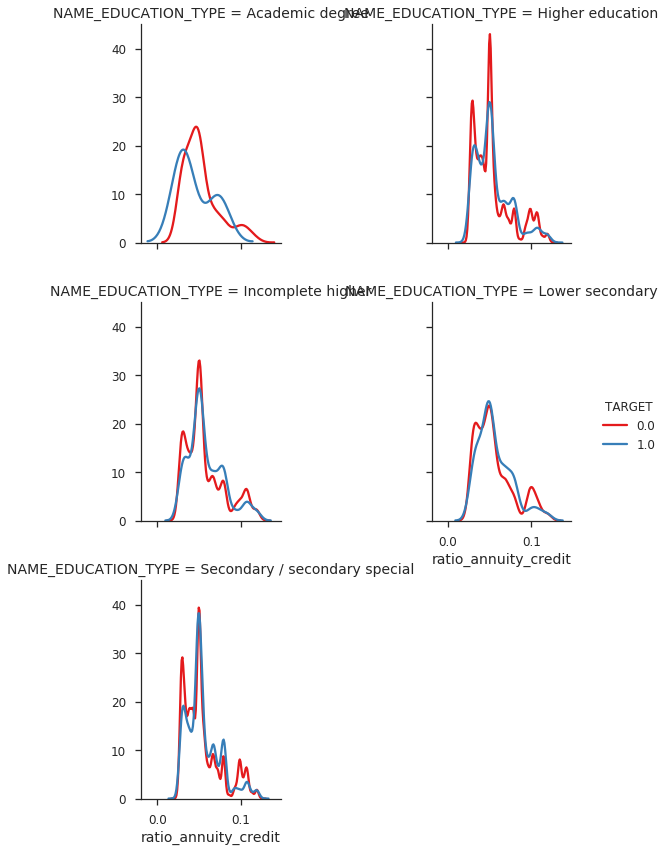

In [23]:
# Relationship between ratio of annuity to credit for different age groups
x = df_raw.loc[:, ['NAME_EDUCATION_TYPE', 'AMT_ANNUITY', 'AMT_CREDIT', 'TARGET']].copy()
x.loc[:, 'ratio_annuity_credit'] = (x.AMT_ANNUITY / x.AMT_CREDIT)

g = sns.FacetGrid(x, 
                  col='NAME_EDUCATION_TYPE', 
                  hue='TARGET', 
                  palette='Set1',
                  size=4,
                  col_wrap=2
                 )
g = g.map(sns.kdeplot, 'ratio_annuity_credit').add_legend()
plt.tight_layout();

#### Goods price vs Target

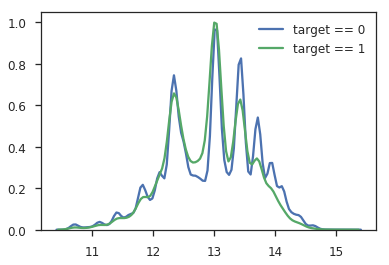

In [25]:
# goods price vs target

t1 = (df_trn[y_trn==0].AMT_GOODS_PRICE.map(np.log1p))
t2 = (df_trn[y_trn==1].AMT_GOODS_PRICE.map(np.log1p))

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

#### Difference between credit and annuity

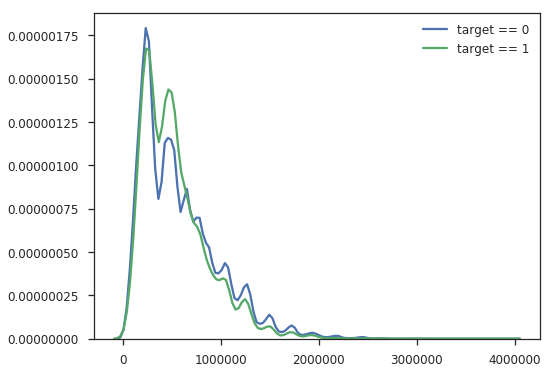

In [32]:
# difference between credit and annuity

plt.figure(figsize=(8, 6))

t1 = (df_trn[y_trn==0].AMT_CREDIT - df_trn[y_trn==0].AMT_ANNUITY)
t2 = (df_trn[y_trn==1].AMT_CREDIT - df_trn[y_trn==1].AMT_ANNUITY)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

#### Difference between goods price and annuity

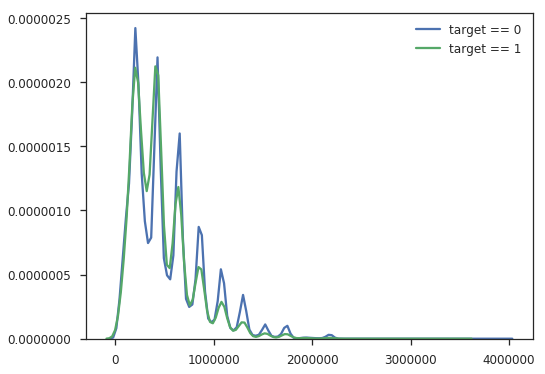

In [33]:
# difference between goods price and annuity

plt.figure(figsize=(8, 6))

t1 = (df_trn[y_trn==0].AMT_GOODS_PRICE - df_trn[y_trn==0].AMT_ANNUITY)
t2 = (df_trn[y_trn==1].AMT_GOODS_PRICE - df_trn[y_trn==1].AMT_ANNUITY)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

#### Relationship between difference of annuity to credit for different age groups

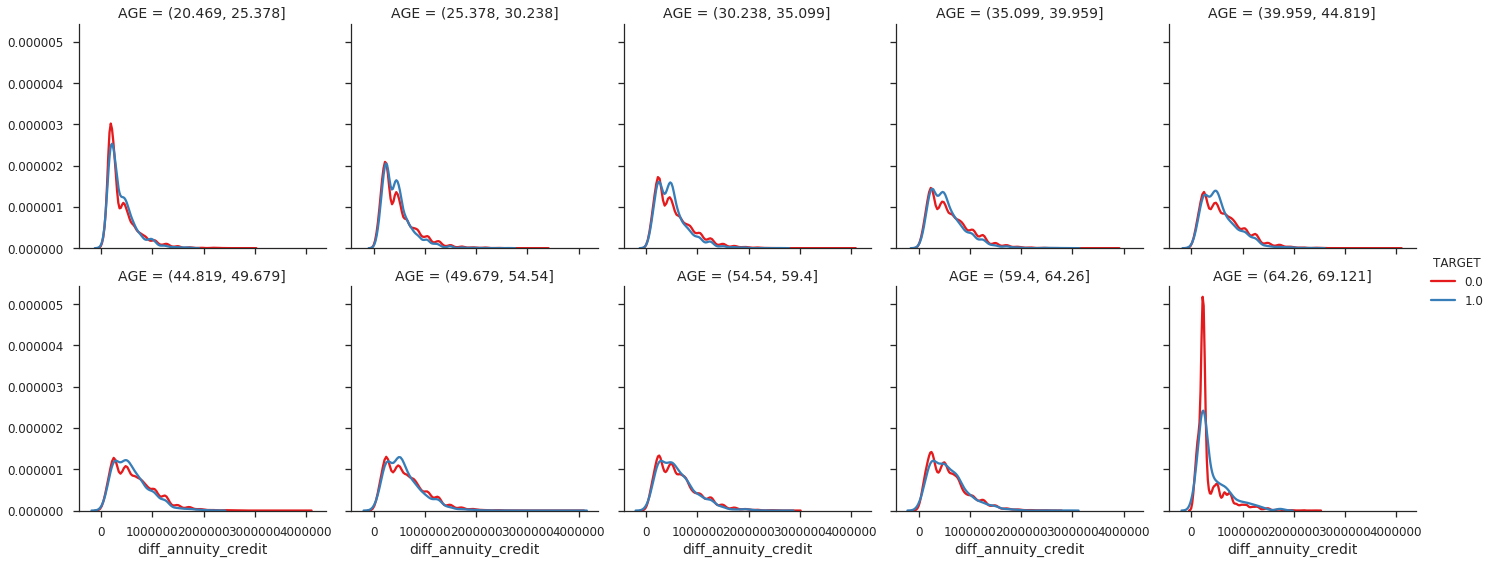

In [38]:
# Relationship between difference of annuity to credit for different age groups
x = df_raw.loc[:, ['DAYS_BIRTH', 'AMT_ANNUITY', 'AMT_CREDIT', 'TARGET']].copy()
x.loc[:, 'AGE'] = pd.cut((-x.DAYS_BIRTH / 365), bins=10)
x.loc[:, 'diff_annuity_credit'] = (x.AMT_CREDIT - x.AMT_ANNUITY)

g = sns.FacetGrid(x, 
                  col='AGE', 
                  hue='TARGET', 
                  palette='Set1',
                  size=4,
                  col_wrap=5
                 )

g = g.map(sns.kdeplot, 'diff_annuity_credit').add_legend();

#### Relationship between difference of annuity to credit for emplyment categories

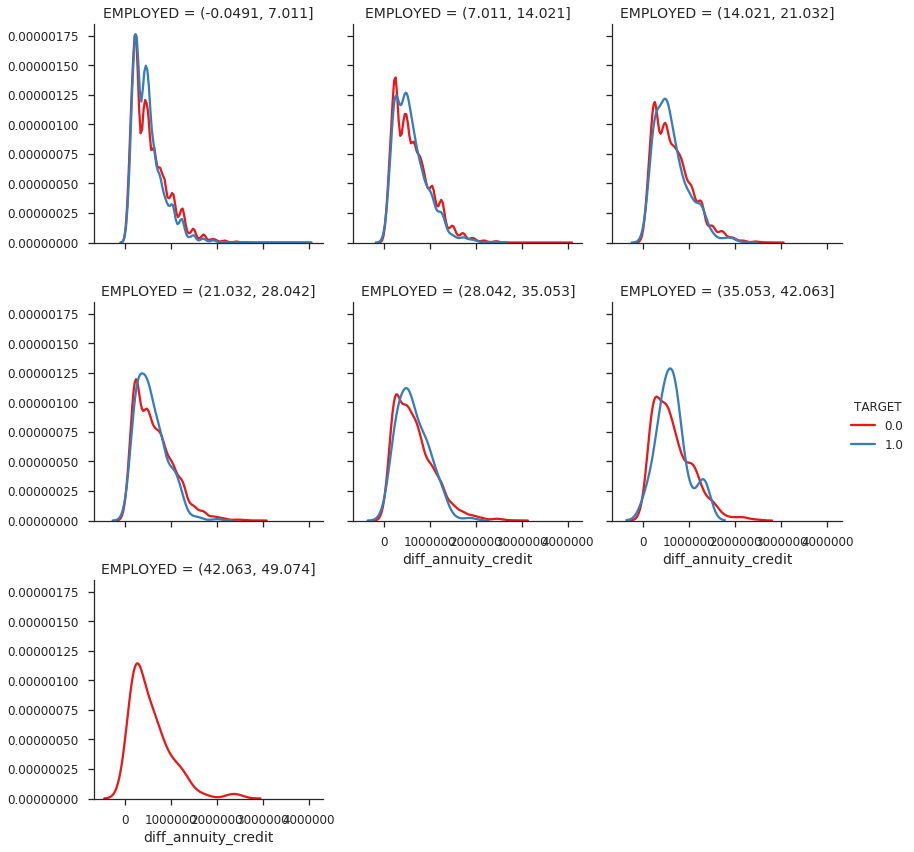

In [47]:
# Relationship between difference of annuity to credit for emplyment categories
x = df_raw.loc[:, ['DAYS_EMPLOYED', 'AMT_ANNUITY', 'AMT_CREDIT', 'TARGET']].copy()
x.loc[:, 'EMPLOYED'] = pd.cut((-x.DAYS_EMPLOYED.replace({365243: np.nan}) / 365), bins=7)
x.loc[:, 'diff_annuity_credit'] = (x.AMT_CREDIT - x.AMT_ANNUITY)

g = sns.FacetGrid(x, 
                  col='EMPLOYED', 
                  hue='TARGET', 
                  palette='Set1',
                  size=4,
                  col_wrap=3
                 )

g = g.map(sns.kdeplot, 'diff_annuity_credit').add_legend();

#### Relationship between difference of annuity to credit for different gender

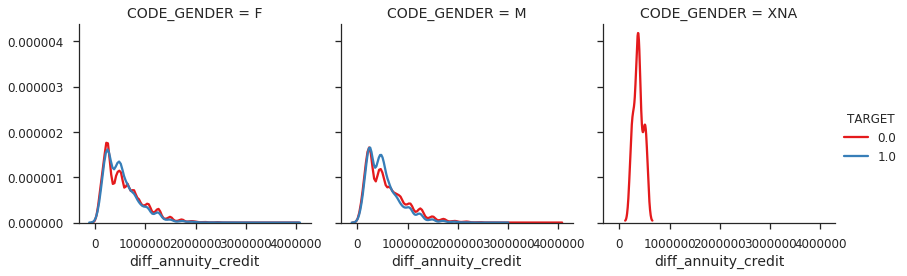

In [44]:
# Relationship between difference of annuity to credit for different gender
x = df_raw.loc[:, ['CODE_GENDER', 'AMT_ANNUITY', 'AMT_CREDIT', 'TARGET']].copy()
x.loc[:, 'diff_annuity_credit'] = (x.AMT_CREDIT - x.AMT_ANNUITY)

g = sns.FacetGrid(x, 
                  col='CODE_GENDER', 
                  hue='TARGET', 
                  palette='Set1',
                  size=4,
                  col_wrap=3
                 )

g = g.map(sns.kdeplot, 'diff_annuity_credit').add_legend();

#### Gender, Age, Days since last time ID was changed and Target

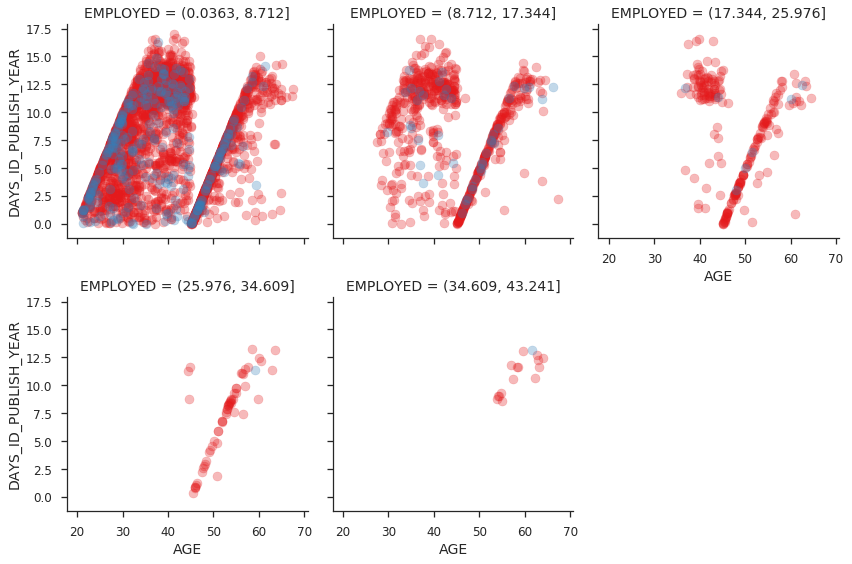

In [50]:
# Gender, Age, Days since last time ID was changed and Target
x = df_raw.loc[:, ['DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'TARGET']].sample(n=5000).copy()
x.loc[:, 'AGE']                  = (-x.DAYS_BIRTH / 365)
x.loc[:, 'EMPLOYED']             = pd.cut((-x.DAYS_EMPLOYED.replace({365243: np.nan}) / 365), bins=5)
x.loc[:, 'DAYS_ID_PUBLISH_YEAR'] = (-x.DAYS_ID_PUBLISH / 365)

g = sns.FacetGrid(x, 
                  col='EMPLOYED', 
                  hue='TARGET', 
                  palette='Set1',
                  size=4,
                  col_wrap=3,
                 )

g = g.map(plt.scatter, 'AGE', 'DAYS_ID_PUBLISH_YEAR', alpha=.3)

#### Relationship between Days ID Publish and AGE

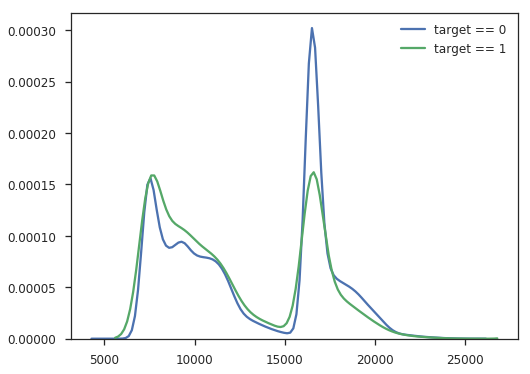

In [65]:
plt.figure(figsize=(8, 6))

t1 = (df_trn[y_trn==0].DAYS_ID_PUBLISH - df_trn[y_trn==0].DAYS_BIRTH)
t2 = (df_trn[y_trn==1].DAYS_ID_PUBLISH - df_trn[y_trn==1].DAYS_BIRTH)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

#### Relationship between DAYS Registration and Days Birth

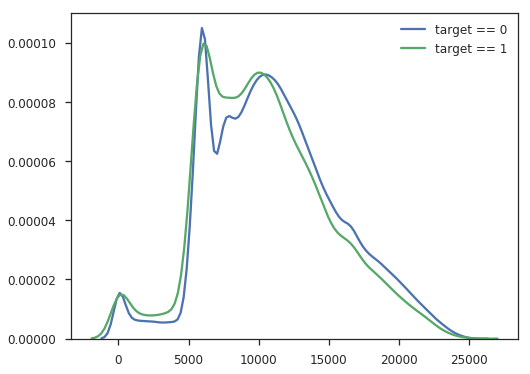

In [61]:
plt.figure(figsize=(8, 6))

t1 = (df_trn[y_trn==0].DAYS_REGISTRATION - df_trn[y_trn==0].DAYS_BIRTH)
t2 = (df_trn[y_trn==1].DAYS_REGISTRATION - df_trn[y_trn==1].DAYS_BIRTH)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

#### Relationship between DAYS Registration and Days ID Publish

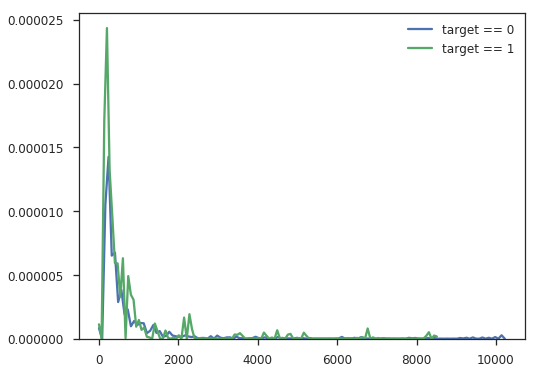

In [63]:
plt.figure(figsize=(8, 6))

t1 = (df_trn[y_trn==0].DAYS_REGISTRATION / df_trn[y_trn==0].DAYS_ID_PUBLISH)
t2 = (df_trn[y_trn==1].DAYS_REGISTRATION / df_trn[y_trn==1].DAYS_ID_PUBLISH)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

### Credit Line Usage

- How to calculate Line of credit ?
    - Line of Credit is the maximum amount of loan customer can borrow from financial institution.
    - In this dataset some credits are reported by Bureau while other are reported directly by Home Credit.

In [281]:
bureau.AMT_CREDIT_SUM_LIMIT.isnull().sum() / len(bureau)

0.3447741472406649

** 34 percent of the values for Credit Limit values are null in the bureau data. **

In [286]:
bureau.groupby('CREDIT_ACTIVE')['AMT_CREDIT_SUM_LIMIT'].apply(lambda x: x.isnull().sum() / len(x))

CREDIT_ACTIVE
Active      0.274843
Bad debt    0.428571
Closed      0.383151
Sold        0.755171
Name: AMT_CREDIT_SUM_LIMIT, dtype: float64

** 27 percent of active credits don't have credit limit values **

In [290]:
active_max_cl = bureau.loc[bureau.CREDIT_ACTIVE == 'Active'].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].max()
active_max_cl[active_max_cl == 0].shape[0] / len(active_max_cl)

0.6509977562893394

** 65 percent of active credits have credit limit value of zero. **

* Let's look at credit balance data provided by Home Credit.

In [6]:
credit_bal.head().T

,0,1,2,3,4
SK_ID_PREV,2562384,2582071,1740877,1389973,1891521
SK_ID_CURR,378907,363914,371185,337855,126868
MONTHS_BALANCE,-6,-1,-7,-4,-1
AMT_BALANCE,56.97,63975.6,31815.2,236572,453919
AMT_CREDIT_LIMIT_ACTUAL,135000,45000,450000,225000,450000
AMT_DRAWINGS_ATM_CURRENT,0,2250,0,2250,0
AMT_DRAWINGS_CURRENT,877.5,2250,0,2250,11547
AMT_DRAWINGS_OTHER_CURRENT,0,0,0,0,0
AMT_DRAWINGS_POS_CURRENT,877.5,0,0,0,11547
AMT_INST_MIN_REGULARITY,1700.32,2250,2250,11795.8,22924.9


In [7]:
credit_bal.loc[credit_bal.AMT_CREDIT_LIMIT_ACTUAL.isnull()].shape[0]

0

** No missing value for credit limit for credits given by Home Credit. **

* Let's look at ratio of balance and credit limit

In [10]:
credit_bal.loc[credit_bal.NAME_CONTRACT_STATUS == 'Active', 
               ['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE',
                'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL'
               ]].head()

,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL
0,378907,2562384,-6,56.970001,135000
1,363914,2582071,-1,63975.554688,45000
2,371185,1740877,-7,31815.224609,450000
3,337855,1389973,-4,236572.109375,225000
4,126868,1891521,-1,453919.468750,450000


In [12]:
credit_bal.NAME_CONTRACT_STATUS.value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

In [13]:
credit_bal.NAME_CONTRACT_STATUS.cat.codes.value_counts()

0    3698436
2     128918
6      11058
3       1365
5        513
4         17
1          5
dtype: int64

In [16]:
tmp = credit_bal.loc[(credit_bal.NAME_CONTRACT_STATUS == 'Active') &\
                     (credit_bal.AMT_CREDIT_LIMIT_ACTUAL > 0)
                     , ['SK_ID_CURR', 'AMT_BALANCE',
                        'AMT_CREDIT_LIMIT_ACTUAL'
                     ]]

t   = tmp.AMT_BALANCE / tmp.AMT_CREDIT_LIMIT_ACTUAL
t   = t.groupby(tmp.SK_ID_CURR).std()
t   = df_raw.SK_ID_CURR.map(t)

print(len(t[t.isnull()]) / len(t))

0.7232424205963364


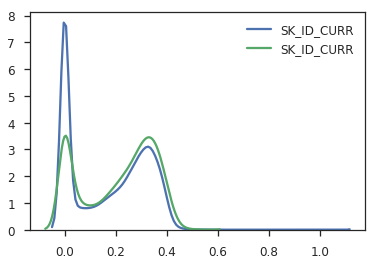

In [17]:
sns.kdeplot(t[df_raw.TARGET==0].map(np.log1p))
sns.kdeplot(t[df_raw.TARGET==1].map(np.log1p))